# Project Group - 

Members: Jarrik Algera, Lorenzo Bouman, Jasper IJsselstein, Joep Neelissen, Tjerk Rijkens


Student numbers: test

# Research Objective

*Requires data modeling and quantitative research in Transport, Infrastructure & Logistics*

The objective of this project is to examine the relationship between weather conditions and train disruptions in the Netherlands. Railway disruption records are combined with meteorological data to quantify the extent to which factors such as precipitation, wind, and temperature are associated with delays and service interruptions. The analysis aims to establish whether specific weather conditions systematically affect railway performance and to what degree. The geographical scale is limited to the Netherlands, and after initial data cleaning and exploratory analyis a specific corridor is chosen. The temporal scale is 2024. 

## Main question

#### *To what extent do weather conditions influence train disruptions in the Netherlands?*

### Sub-questions

*Are disruptions more frequent on days with adverse weather compared to days with mild weather?*


*Do disruption durations increase under heavy precipitation, strong wind, or temperature extremes?*


*Which weather variable shows the strongest association with disruption frequency?*


*Are there seasonal differences in how weather affects train disruptions?*


*Are there regional variations in the relationship between weather and disruptions?*

# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Author 1**: N/A

**Author 2**: N/A

**Author 3**: N/A

# Data Used

## Datasets

Two primary datasets are available for this study. The first dataset contains records of train disruptions in the Netherlands between 2011 and 2024. Each record provides details on the type of disruption (for example staffing problems or a signal failure), its duration, the time of occurrence, and the affected trajectory (for example Eindhoven - Venlo, Nijmegen - Venlo). This dataset represents the dependent variable, as it directly reflects railway system performance. The dataset is obtained from Rijden de Treinen (https://www.rijdendetreinen.nl/open-data/treinstoringen#downloads). It is important to realize that not every train that is delayed or cancelled is communicated by NS as a disruption; the rule of thumb that NS uses is that a disruption is communicated when multiple trains are delayed or cancelled (i.e. a major impact of the train service). The dataset is provided as a .csv file.

The second dataset is derived from the Royal Netherlands Meteorological Institute (KNMI) (https://www.daggegevens.knmi.nl/klimatologie/uurgegevens) and provides hourly weather observations. It includes variables such as precipitation intensity, temperature, and wind speed and direction. Not every weather station measures all these variables. Therefore, it is necessary to make a selection of usable stations. These variables serve as independent factors to explain variation in railway disruptions.

# Data Pipeline

## Intended Data Analysis Pipeline

### The planned analysis will follow several stages:

The planned analysis will follow several stages:

##### 1. Data cleaning and preparation
- Align disruption data with corresponding weather observations based on time and location. Thus should be executed on an hourly basis for proper comparison. 
- Filter data to dataframe of weather data in 2024. 
- Base data from weather stations on chosen train trajectory. 
- Filter through weather stations to exclude stations without rain and temperature measurements.
- Choose appropriate parameters related to the weather data to use in analysis


##### 2. Exploratory analysis
- Compute descriptive statistics for disruption frequency and duration.
- Visualize weather variables alongside disruptions to detect initial patterns.

##### 3. Correlation analysis
- Assess associations between weather conditions and disruption frequency or duration.

##### 4. Modeling
- Apply regression models to estimate the effect of precipitation, wind, and temperature on disruption likelihood and duration.
- Investigate seasonal and regional variation in the relationship between weather and disruptions.

##### 5. Evaluation and visualization
- Present results using time series plots, scatterplots, and heatmaps, alongside statistical measures.


In [2]:
%run load_weather_data


In [3]:
import pandas as pd
import plotly.express as px
import os

df_stations = pd.read_parquet(os.path.join(os.getcwd(),r"data\df_stations.parquet"))
print(df_stations.head())

fig = px.scatter_map(
    df_stations,
    lat="LAT(north)",
    lon="LON(east)",
    hover_name="NAME",        # Column to appear in bold in the hover tooltip
    hover_data=["STN"],       # Additional data to appear in the tooltip
    color_discrete_sequence=["blue"], # Set marker color
    zoom=7,                   # Initial map zoom level
    title="Weather Stations in the Netherlands"
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0, "t":40, "l":0, "b":0} # Adjust margins
)

# 4. Show the figure
fig.show()


   STN  LON(east)  LAT(north)  ALT(m)                NAME
2  215      4.437      52.141    -1.1         Voorschoten
4  235      4.781      52.928     1.2             De Kooy
5  240      4.790      52.318    -3.3            Schiphol
8  249      4.979      52.644    -2.4            Berkhout
9  251      5.346      53.392     0.7  Hoorn Terschelling


Schiphol, De Bilt, Cabauw Mast, Rotterdam, Voorschoten


In [4]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import os

# 1. Sample DataFrame with station locations and weather data
#    (Replace with your actual DataFrame)
data = {
    'STN': [215, 235, 240, 249, 251, 260, 267],
    'LON(east)': [4.437, 4.781, 4.790, 4.979, 5.346, 5.180, 5.384],
    'LAT(north)': [52.141, 52.928, 52.318, 52.644, 53.392, 52.100, 52.898],
    'NAME': ['Voorschoten', 'De Kooy', 'Schiphol', 'Berkhout', 'Hoorn Terschelling', 'De Bilt', 'Stavoren'],
    'Temperature_C': [15.2, 14.8, 15.5, 14.9, 14.1, 15.6, 14.5],
    'Wind_Speed_kmh': [22, 28, 25, 26, 35, 19, 30]
}
df_stations = pd.DataFrame(data)




def find_closest_stations(input_lat, input_lon, stations_df):
    """Finds the 3 closest weather stations to a given lat/lon point."""
    input_location = (input_lat, input_lon)
    
    distances = stations_df.apply(
        lambda row: geodesic(input_location, (row['LAT(north)'], row['LON(east)'])).km,
        axis=1
    )
    
    df_with_dist = stations_df.copy()
    df_with_dist['distance_km'] = distances
    
    return df_with_dist.sort_values('distance_km').head(3)


def get_weighted_average_weather(closest_stations_df):
    """
    Calculates the weighted average of weather data from the closest stations
    using Inverse Distance Weighting (IDW).
    
    Returns:
        A dictionary with the interpolated weather data.
    """
    # Handle the edge case where the location is exactly at a station
    if closest_stations_df['distance_km'].iloc[0] < 0.01: # less than 10 meters
        # Return the data from the first station directly
        first_station = closest_stations_df.iloc[0]
        weather_cols = ['Temperature_C', 'Wind_Speed_kmh'] # Define weather columns
        return first_station[weather_cols].to_dict()

    # Calculate inverse distance weights
    weights = 1 / closest_stations_df['distance_km']
    sum_of_weights = np.sum(weights)
    
    weighted_averages = {}
    
    # Iterate through the weather data columns to calculate the weighted average
    weather_cols_to_average = ['Temperature_C', 'Wind_Speed_kmh']
    
    for col in weather_cols_to_average:
        weighted_sum = np.sum(closest_stations_df[col] * weights)
        weighted_average = weighted_sum / sum_of_weights
        weighted_averages[col] = weighted_average
        
    return weighted_averages


# --- EXAMPLE USAGE ---

# 1. Manually enter a location (e.g., Rotterdam Centraal)
my_lat = 51.9225
my_lon = 4.47917

# 2. Find the 3 closest stations
closest_stations = find_closest_stations(my_lat, my_lon, df_stations)

print("The 3 closest stations to your location are:")
print(closest_stations[['NAME', 'STN', 'distance_km', 'Temperature_C', 'Wind_Speed_kmh']])
print("-" * 50)

# 3. Calculate and display the interpolated weather data for that location
interpolated_weather = get_weighted_average_weather(closest_stations)

print("Interpolated weather data for your location:")
print(f"Estimated Temperature: {interpolated_weather['Temperature_C']:.2f}°C")
print(f"Estimated Wind Speed: {interpolated_weather['Wind_Speed_kmh']:.2f} km/h")

The 3 closest stations to your location are:
          NAME  STN  distance_km  Temperature_C  Wind_Speed_kmh
0  Voorschoten  215    24.483698           15.2              22
2     Schiphol  240    48.886385           15.5              25
5      De Bilt  260    52.014654           15.6              19
--------------------------------------------------
Interpolated weather data for your location:
Estimated Temperature: 15.37°C
Estimated Wind Speed: 22.05 km/h


In [5]:
%run plot_train_stations.py

C:\Users\tjrij\Documents\TIL-groepje-1\plot_train_stations.py:63: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\tjrij\Documents\TIL-groepje-1\plot_train_stations.py:77: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [7]:
import pandas as pd
from geopy.distance import geodesic
import os

# control current working map
print("Current working directory:", os.getcwd())

#Rea d staions data
df = pd.read_csv('data/stations-2023-09.csv')

#centre of circle — Bodegraven
center_lat = 52.0822
center_lon = 4.7447
radius_km = 70  # Straal in kilometers

# Is the station in the circle
def within_radius(row):
    station_loc = (row['geo_lat'], row['geo_lng'])
    center_loc = (center_lat, center_lon)
    distance = geodesic(center_loc, station_loc).km
    return distance <= radius_km

#Filter stations within the circle
df_circle = df[df.apply(within_radius, axis=1)]

# save as CSV
output_path = 'data/stations_within_circle.csv'
df_circle.to_csv(output_path, index=False)

#  show results
print(f"{len(df_circle)} stations gevonden binnen {radius_km} km van Bodegraven.")
print(f"Bestand opgeslagen als: {output_path}")
df_circle.head()

Current working directory: c:\Users\tjrij\Documents\TIL-groepje-1
184 stations gevonden binnen 70 km van Bodegraven.
Bestand opgeslagen als: data/stations_within_circle.csv


,id,code,uic,name_short,name_medium,name_long,slug,country,type,geo_lat,geo_lng
0,266,HT,8400319,Den Bosch,'s-Hertogenbosch,'s-Hertogenbosch,s-hertogenbosch,NL,knooppuntIntercitystation,51.690480,5.293620
1,269,HTO,8400320,Dn Bosch O,'s-Hertogenb. O.,'s-Hertogenbosch Oost,s-hertogenbosch-oost,NL,stoptreinstation,51.700554,5.318333
6,5,AC,8400047,Abcoude,Abcoude,Abcoude,abcoude,NL,stoptreinstation,52.278500,4.977000
13,26,AMR,8400050,Alkmaar,Alkmaar,Alkmaar,alkmaar,NL,knooppuntIntercitystation,52.637779,4.739722
14,28,AMRN,8400052,Alkmaar N,Alkmaar Noord,Alkmaar Noord,alkmaar-noord,NL,stoptreinstation,52.643890,4.764167


In [17]:
pd.read_parquet('data/df_weather_5_stations.parquet')

,STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,Q,DR,RH,VV,M,R,S,O,Y
0,215,20240101,1,210,100,110,160,72,NaN,0,10,13,56,0,1,0,0,0
1,215,20240101,2,210,90,70,150,75,NaN,0,4,6,61,0,1,0,0,0
2,215,20240101,3,210,80,70,120,74,NaN,0,3,9,50,0,1,0,0,0
3,215,20240101,4,240,70,80,130,89,NaN,0,3,4,67,0,1,0,0,0
4,215,20240101,5,240,80,80,130,92,NaN,0,0,-1,66,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43915,348,20241231,20,200,100,100,160,59,NaN,0,0,0,71,0,0,0,0,0
43916,348,20241231,21,210,120,120,180,63,NaN,0,0,0,74,0,0,0,0,0
43917,348,20241231,22,210,110,100,170,68,NaN,0,0,0,74,0,0,0,0,0
43918,348,20241231,23,210,110,110,160,75,NaN,0,0,0,71,0,0,0,0,0


In [18]:
print(df_weather.columns.tolist())

['STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10N', 'Q', 'DR', 'RH', 'VV', 'M', 'R', 'S', 'O', 'Y']


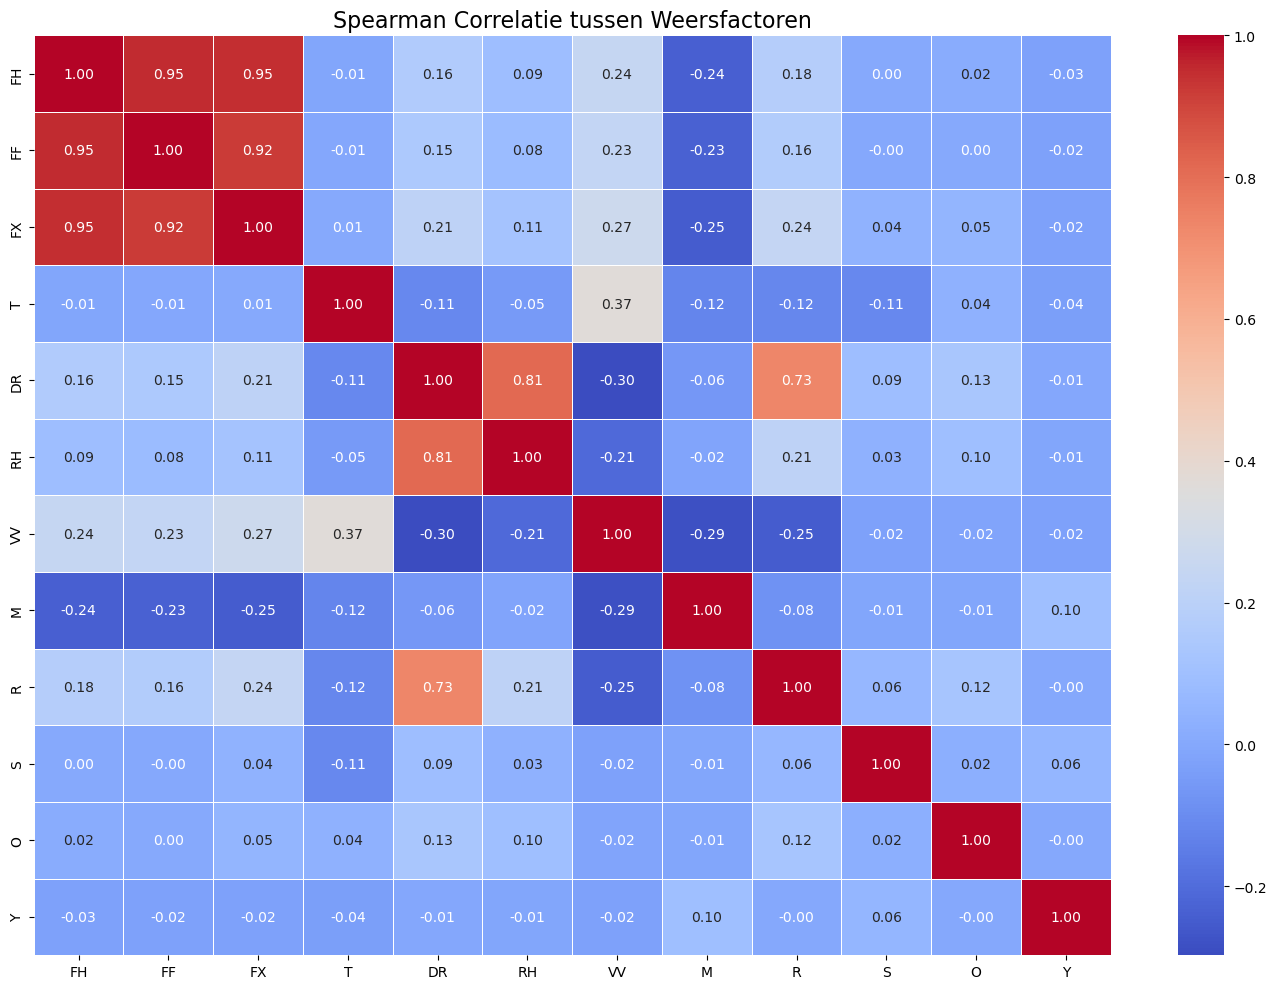

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 📥 Weerdata inladen
df_weather = pd.read_parquet('data/df_weather_5_stations.parquet')

# 2. ⚙️ Kolommen selecteren (DD = windrichting nemen we niet mee)
weather_cols = [
    'FH',  # uur gemiddelde windsnelheid
    'FF',  # windsnelheid
    'FX',  # windstoot
    'T',   # temperatuur
    'DR',  # duur neerslag
    'RH',  # hoeveelheid neerslag
    'VV',  # zicht
    # 'N',  # bewolking (ontbreekt bij jou)
    # 'U',  # relatieve vochtigheid (ontbreekt bij jou)
    'M',   # mist (binair)
    'R',   # regen (binair)
    'S',   # sneeuw (binair)
    'O',   # onweer (binair)
    'Y'    # ijzel (binair)
]

df_weather_sel = df_weather[weather_cols].copy()

# 3. 🧮 Waarden omrekenen (wind, temp en neerslag in echte eenheden)
df_weather_sel['FH'] /= 10
df_weather_sel['FF'] /= 10
df_weather_sel['FX'] /= 10
df_weather_sel['T']  /= 10
df_weather_sel['RH'] /= 10
df_weather_sel['DR'] /= 10

# 4. 🧼 Missende waarden afhandelen
# (je kunt ook imputatie gebruiken, maar voor nu droppen we ze)
df_weather_sel = df_weather_sel.dropna()

# 5. 🧮 Correlatiematrix berekenen (Spearman is beter voor mix binair + continu)
corr_matrix = df_weather_sel.corr(method='spearman')

# 6. 📊 Heatmap plotten
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title('Spearman Correlatie tussen Weersfactoren', fontsize=16)
plt.tight_layout()
plt.show()

# 7. 📌 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# HIER KOMT JE DISRUPTIONS DATA STRAKS BIJ
# Voorbeeldstap (als je straks je disruptions dataframe hebt):
# df_disruptions = pd.read_csv('data/disruptions_2024.csv')
# disruptions_cols = ['vertraging_totaal', 'aantal_verstoringen', ...]  # jouw 15 variabelen
# 
# # Zorg dat je de data per tijdseenheid kan koppelen (bijv. per dag of uur)
# # door bijvoorbeeld:
# # - df_weather_sel['YYYYMMDD'] toevoegen
# # - groupby('YYYYMMDD') en mean() of sum() gebruiken
#
# merged = df_weather_sel.join(df_disruptions[disruptions_cols])
# full_corr = merged.corr(method='spearman')
#
# # Heatmap met weersfactoren + disruptions
# sns.heatmap(full_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Correlatie tussen Weer en Treinverstoringen')
# plt.show()
#  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


C:\Users\jarri\AppData\Local\Temp\ipykernel_2712\201187746.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_disruptions['datetime'] = df_disruptions['start_time'].dt.floor('H')
C:\Users\jarri\AppData\Local\Temp\ipykernel_2712\201187746.py:101: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Anaconda3\envs\TIL6022-25\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


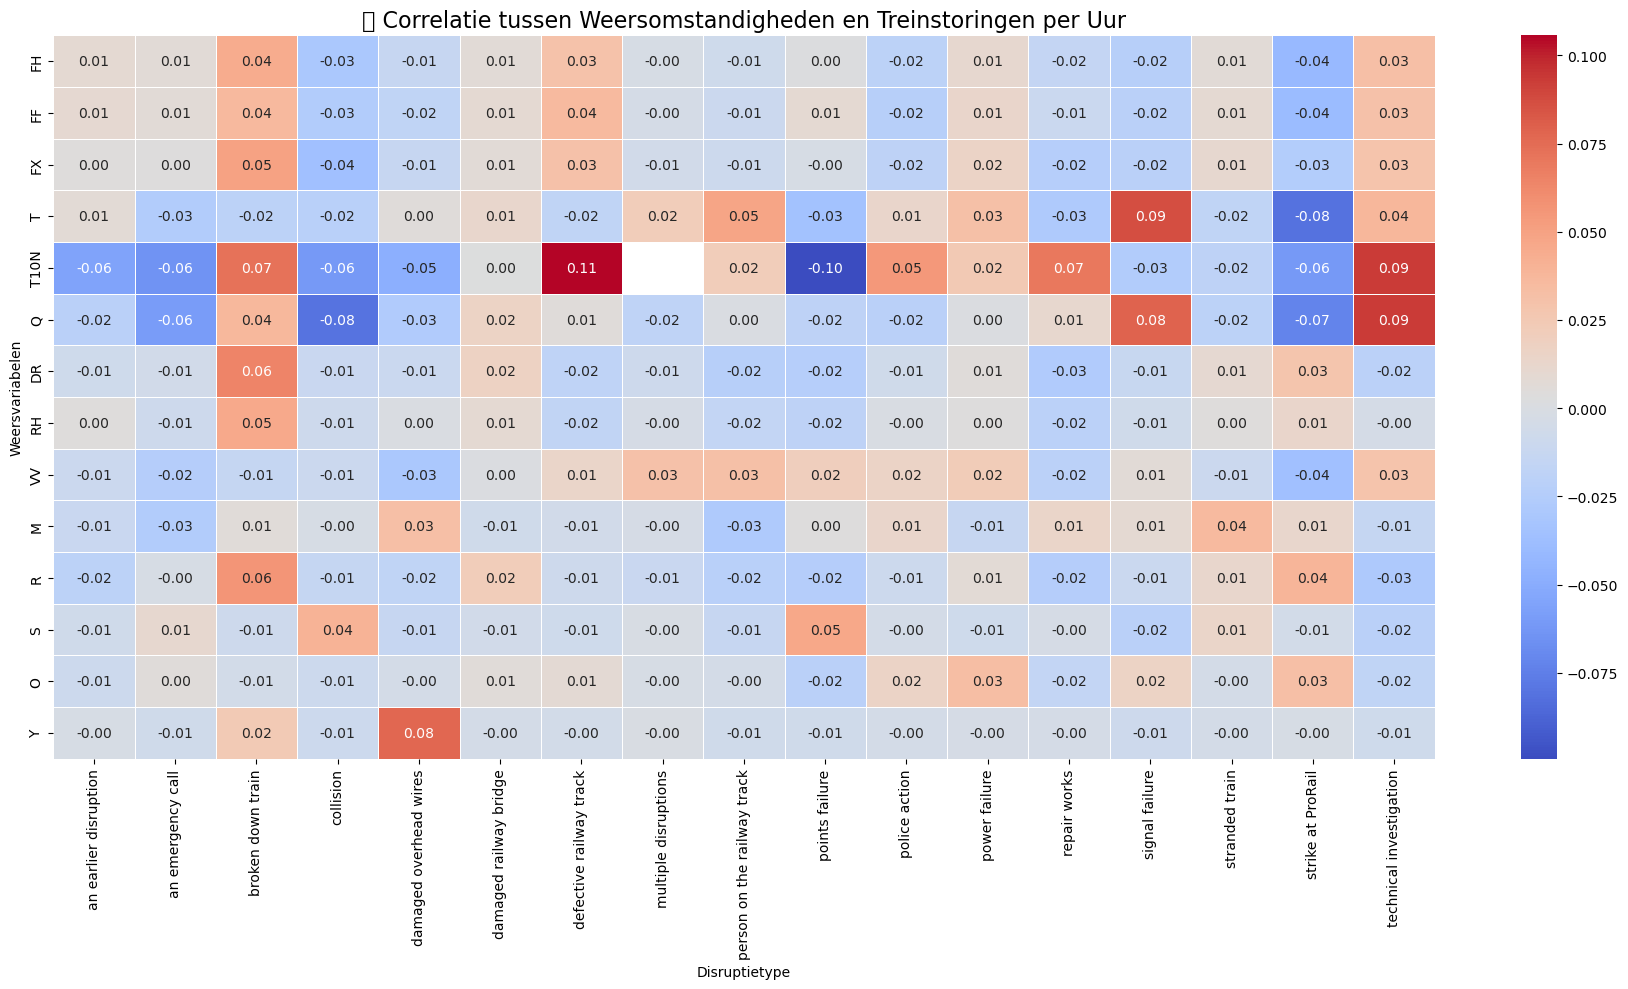

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Loading weather data
df_weather = pd.read_parquet('data/df_weather_5_stations.parquet')

# HH as string. 
df_weather['HH'] = df_weather['HH'].astype(str).str.zfill(2)

# Merge YYYYMMDD and HH to datetime string
df_weather['datetime_str'] = df_weather['YYYYMMDD'].astype(str) + df_weather['HH']

# filter for correct rows
df_weather = df_weather[df_weather['datetime_str'].str.len() == 10]

# change to datetime
df_weather['datetime'] = pd.to_datetime(
    df_weather['datetime_str'], 
    format='%Y%m%d%H', 
    errors='coerce'
)

# Eventuele mislukte conversies eruit
df_weather = df_weather.dropna(subset=['datetime'])

# Select relevant columns
weather_cols = ['FH','FF','FX','T','T10N','Q','DR','RH','VV','M','R','S','O','Y']
df_weather_sel = df_weather[['datetime'] + weather_cols].copy()

# Correct units
for col in ['FH','FF','FX','T','RH','DR']:
    df_weather_sel[col] = df_weather_sel[col] / 10

# Load disruptions
df_disruptions = pd.read_csv('data/disruptions_filtered_top15_causes.csv')

# Unify start times. 
df_disruptions['start_time'] = pd.to_datetime(df_disruptions['start_time'])
df_disruptions['datetime'] = df_disruptions['start_time'].dt.floor('H')

# Create pivot table of the disruptions. 
df_disruptions['flag'] = 1
df_disruption_pivot = (
    df_disruptions
    .pivot_table(
        index='datetime',
        columns='cause_en',   # English description of cause
        values='flag',
        aggfunc='sum',        # number of disruptions per hour per type
        fill_value=0
    )
    .reset_index()
)

# Merge weather and disruptions
merged = pd.merge(df_weather_sel, df_disruption_pivot, on='datetime', how='inner')

scaler = StandardScaler()
merged[weather_cols] = scaler.fit_transform(merged[weather_cols])


# Correlation calculations
all_cols = merged.columns.tolist()
disruption_cols = [c for c in all_cols if c not in weather_cols + ['datetime']]

# Spearman correlation 
corr_matrix = merged.drop(columns=['datetime']).corr(method='spearman')

# Weather vs disruption in the matrix.
corr_sub = corr_matrix.loc[weather_cols, disruption_cols]

# Plot the heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(
    corr_sub,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('📊 Correlatie tussen Weersomstandigheden en Treinstoringen per Uur', fontsize=16)
plt.xlabel('Disruptietype')
plt.ylabel('Weersvariabelen')
plt.tight_layout()
plt.show()